In [1]:
import argparse
from diffusers import AutoPipelineForText2Image
from diffusers import DiffusionPipeline, LCMScheduler
import torch
import json
import os
import sys

/shared/anaconda3/envs/cs_transformer/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Code to generate image via SD1.5

In [2]:
# Load the model
pipeline = AutoPipelineForText2Image.from_pretrained(
    "runwayml/stable-diffusion-v1-5", torch_dtype=torch.float16, variant="fp16"
).to("cuda")
image = pipeline("A smiling young woman with long brown hair, wearing a red t-shirt, standing against a plain white wall.").images[0]

100%|██████████| 50/50 [00:03<00:00, 16.00it/s]


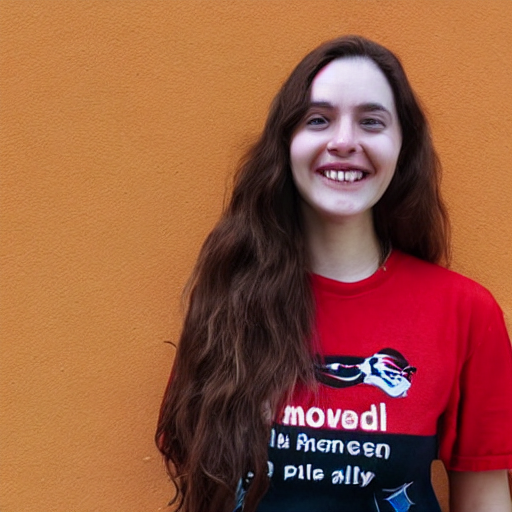

In [3]:
image

# Code to generate via SDXL

In [4]:
import torch
from diffusers import DiffusionPipeline, LCMScheduler

pipe = DiffusionPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0",
    variant="fp16",
    torch_dtype=torch.float16
).to("cuda")

# set scheduler
pipe.scheduler = LCMScheduler.from_config(pipe.scheduler.config)

# load LCM-LoRA
pipe.load_lora_weights("latent-consistency/lcm-lora-sdxl")

prompt = "A smiling young woman with long brown hair, wearing a red t-shirt, standing against a plain white wall."

generator = torch.manual_seed(42)
image = pipe(
    prompt=prompt, num_inference_steps=4, generator=generator, guidance_scale=1.0
).images[0]

Loading pipeline components...: 100%|██████████| 7/7 [00:04<00:00,  1.48it/s]
The config attributes {'skip_prk_steps': True} were passed to LCMScheduler, but are not expected and will be ignored. Please verify your scheduler_config.json configuration file.
100%|██████████| 4/4 [00:01<00:00,  3.51it/s]


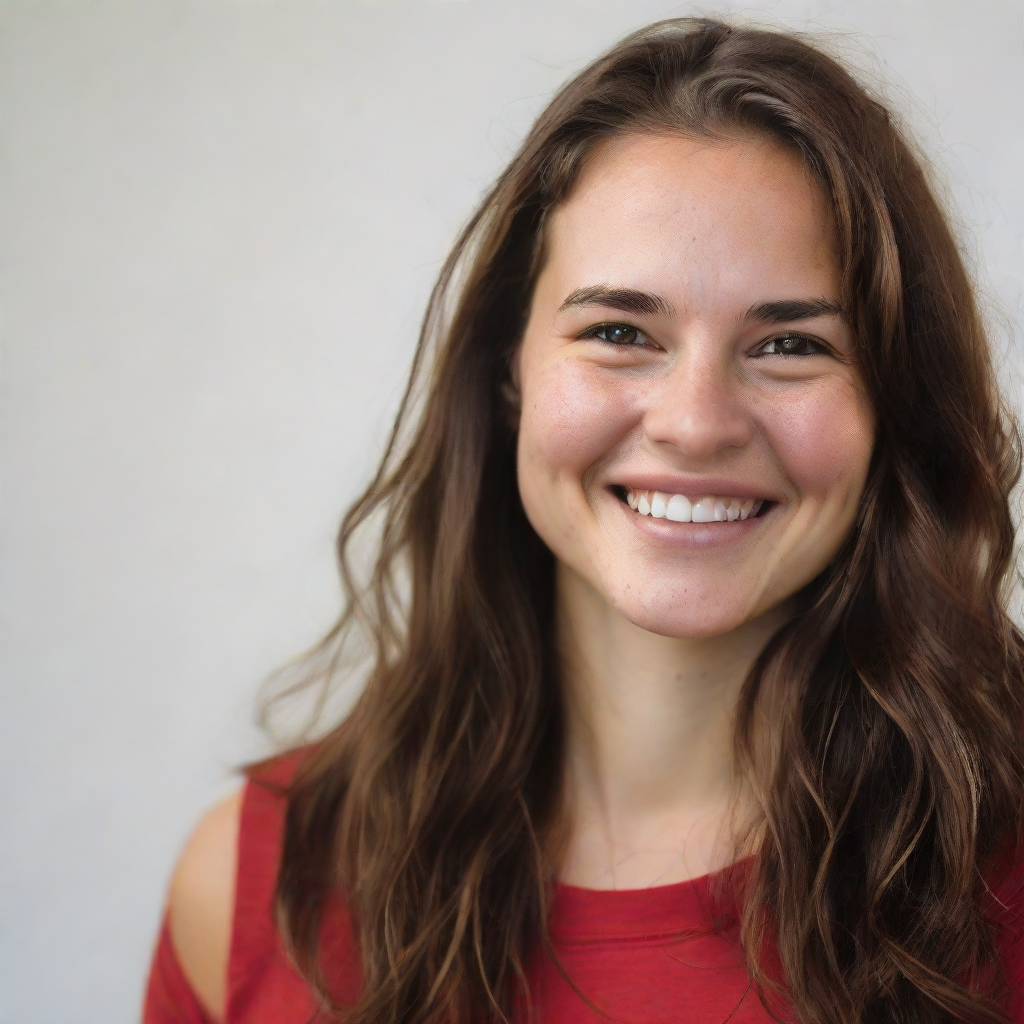

In [5]:
image

# Generate Captions using Florence model

In [2]:
from florence_2_captions import analyze_image

# Use the function
result = analyze_image('/lustre/shared/charchit/generated_images/simple_prompts_sd1.5/image_1.png', '<DETAILED_CAPTION>')
print(result)

/shared/anaconda3/envs/cs_transformer/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/shared/anaconda3/envs/cs_transformer/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/shared/anaconda3/envs/cs_transformer/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


{'<DETAILED_CAPTION>': 'The image shows a woman with long brown hair wearing a red t-shirt, smiling at the camera against a red background.'}


In [3]:
result['<DETAILED_CAPTION>']

'The image shows a woman with long brown hair wearing a red t-shirt, smiling at the camera against a red background.'

# Below code tests the generate caption and it's original prompt 

In [7]:
from compare_two_texts import compare_texts


text1 = 'The image shows a woman with long brown hair wearing a red t-shirt, smiling at the camera against a red background.'
text2 = "A smiling young woman with long brown hair, wearing a red t-shirt, standing against a plain white wall."

similarity_score = compare_texts(text1, text2)
print('similarity_score between two texts is :', similarity_score)

similarity_score between two texts is : 0.7365995049476624


# Below Code test's the similarity between geneted image and it's prompts

In [11]:
import os

def find_simple_folders(root_path):

    simple_folders = []
    
    # Walk through the directory
    for dirpath, dirnames, filenames in os.walk(root_path):
        # Check each directory name
        for dirname in dirnames:
            if dirname.startswith('simple_'):
                # If it starts with 'simple_', add its full path to our list
                full_path = os.path.join(dirpath, dirname)
                simple_folders.append(full_path)
    
    return simple_folders

root_directory = '/lustre/shared/charchit/generated_images'
simple_folders = find_simple_folders(root_directory)
    


In [13]:
from clip_similarity_score import compare_text_image


temp = {}
for folder in simple_folders:
    print(folder)
    image_path = f'{folder}/image_1.png'
    text = "A middle-aged woman with curly red hair, laughing and wearing a yellow sundress, standing in front of a beige curtain."
    
    folder_name = folder.split('/')[-1]
    similarity_score = compare_text_image(image_path, text)
    temp[folder_name] = similarity_score
    print(f"Similarity between image and text: folder name {folder_name}, score : {similarity_score}")


/lustre/shared/charchit/generated_images/simple_prompts_sd1.5
Similarity between image and text: folder name simple_prompts_sd1.5, score : 0.22647446393966675
/lustre/shared/charchit/generated_images/simple_prompts_lcmLORA
Similarity between image and text: folder name simple_prompts_lcmLORA, score : 0.20120835304260254
/lustre/shared/charchit/generated_images/simple_prompts_juggernaut


Similarity between image and text: folder name simple_prompts_juggernaut, score : 0.17146426439285278
/lustre/shared/charchit/generated_images/simple_prompts_sdxl_refiner
Similarity between image and text: folder name simple_prompts_sdxl_refiner, score : 0.18900881707668304
/lustre/shared/charchit/generated_images/simple_prompts_sdxl
Similarity between image and text: folder name simple_prompts_sdxl, score : 0.18485543131828308
/lustre/shared/charchit/generated_images/simple_prompts_sdxl_refiner_v2
Similarity between image and text: folder name simple_prompts_sdxl_refiner_v2, score : 0.19959694147109985
/lustre/shared/charchit/generated_images/simple_prompts_jg_lcm
Similarity between image and text: folder name simple_prompts_jg_lcm, score : 0.16827258467674255


In [ ]:
# 186M    ./super_resolution/Real-ESRGAN/gfpgan/weights
# 186M    ./super_resolution/Real-ESRGAN/gfpgan
# 105M    ./super_resolution/Real-ESRGAN/gfpgan/weights/detection_Resnet50_Final.pth